In [1]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt
%matplotlib inline

# NVT Simulation Validation

This notebook implements a simple test to validate that the NVT MC code produces correct configurations. 

## Reference

> Merz PT, Shirts MR (2018) Testing for physical validity in molecular simulations. PLoS ONE 13(9): e0202764. https://doi.org/10.1371/journal.pone.0202764  
> Shirts, "M. R. Simple Quantitative Tests to Validate Sampling from Thermodynamic Ensembles", J. Chem. Theory Comput., 2013, 9 (2), pp 909–926, http://dx.doi.org/10.1021/ct300688p

## Derivation

The probability density in the canonical ensemble reads

\begin{align}
    P(\bar{x} | \beta) \propto e^{-\beta {\cal H}(\bar{p}, \bar{q})} \,,
\end{align}

where $\bar{x} = (\bar{p}, \bar{q}, \bar{N}, V)$ denotes a microstate.
The probability of observing a specific energy $E$ in the canonical ensemble is:

\begin{align}
P(E | \beta) &= \frac{\Omega(E)}{Q(\beta)} e^{-\beta E} \,,
\end{align}

with the density of states (micro canonical partition function)
\begin{align}
\Omega(E) &= \int e^{\frac{S(N, V, E)}{k_b}} \mathrm{d}E \,,
\end{align}

and the canonical partition function
\begin{align}
Q(\beta) &= \int \Omega(E) e^{-\beta E} \mathrm{d}E
\end{align}

For a given $\bar{N}, V$, the micro canonical partition function is a function of only the energy while the canonical partition function is a function of only the temperature.
Consider two simulations at different (inverse) temperatures, $\beta_1$ and $\beta_2$, in which we observe common energies, $E$, in both simulations.
Since the micro canonical partition function is a function of only the energy, for an energy that is observed in both simulations, the micro canonical probability must be the same for both simulations.

Thus, we can write:

\begin{align}
P(E | \beta_1) Q(\beta_1) e^{\beta_1 E} = P(E | \beta_2) Q(\beta_2) e^{\beta_2 E}
\end{align}

solving for the ratio of probabilities:

\begin{align}
\frac{P(E | \beta_2)}{P(E | \beta_1)} &= \frac{Q(\beta_1)}{Q(\beta_2)} \frac{e^{-\beta_2 E}}{e^{-\beta_1 E}} \,,
\end{align}

which we can rewrite, taking the logarithm and using $Q(\beta) = e^{-\beta A}$,

\begin{align}
\ln \left[\frac{P(E | \beta_2)}{P(E | \beta_1)} \right] &= \color{blue}{(\beta_2 A_2 - \beta_1 A_1)} \color{red}{-(\beta_2 - \beta_1)} E\,, \\
&= \color{blue}{a_0} + \color{red}{a_1} E
\end{align}

The lefthand side of the last equation can be determined from simulations by creating histograms of time series of energies. When plotted versus the energy, the resulting graph has to be a line with slope $a_1$ which is simply the negative difference of the inverse temperatures, which is known.

In [4]:
# Helper functions to build and run simulations

def build_nvt(n, rho, t, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(n, rho)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    mc = MonteCarlo([displace_particle], [1], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_simulation(simulation, equilibration, production):
    simulation.run(equilibration)
    simulation.deactivate_propagator_updates()
    
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    
    # widom = Observer.widom_insertion(100)
    # simulation.add_observer(widom)
    
    simulation.run(production)
    return pd.DataFrame(properties.data)

In [5]:
nparticles = 500
density = 8e-1
volume = nparticles / density
rc = 3.0
tail_correction = True

In [443]:
%%time
t1 = 8e-1
sim1, sys1 = build_nvt(500, 8e-1, t1, rc, True)
props1 = run_simulation(sim1, 500*5000, 500*50000)

CPU times: user 4min 33s, sys: 553 ms, total: 4min 34s
Wall time: 4min 33s


In [444]:
%%time
t2 = 9e-1
sim2, sys2 = build_nvt(500, 8e-1, t2, rc, True)
props2 = run_simulation(sim2, 500*5000, 500*50000)

CPU times: user 4min 32s, sys: 434 ms, total: 4min 32s
Wall time: 4min 32s


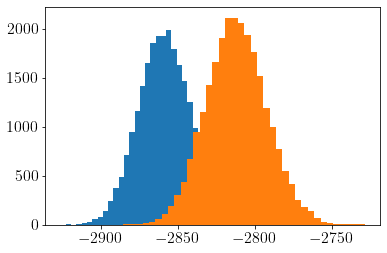

In [446]:
_ = plt.hist(props1.energy, bins=40)
_ = plt.hist(props2.energy, bins=40)

In [448]:
import pymbar

e1 = props1.energy.values[pymbar.timeseries.subsampleCorrelatedData(props1.energy)]
e2 = props2.energy.values[pymbar.timeseries.subsampleCorrelatedData(props2.energy)]

In [445]:
t0, g, _ = pymbar.timeseries.detectEquilibration(props1.energy)
e1 = props1.energy.values[t0::g]

t0, g, _ = pymbar.timeseries.detectEquilibration(props2.energy)
e2 = props2.energy.values[t0::g]

TypeError: slice indices must be integers or None or have an __index__ method

In [449]:
rng = max(e1.min(), e2.min()), min(e1.max(), e2.max())

In [453]:
bins = 15
h1, edges = np.histogram(e1, bins=bins, range=rng)#, normed=True)
h2, _ = np.histogram(e2, bins=bins, range=rng)#, normed=True)
centers = 0.5*(edges[1:]+ edges[:-1])

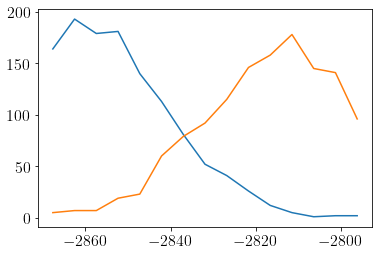

In [454]:
plt.plot(centers, h1)
plt.plot(centers, h2)

In [455]:
var = 1 / h1 - 1 / np.sum(h1) + 1 / h2 - 1 / np.sum(h2)
m, b = np.polyfit(centers, np.log(h2 / h1), 1, w=1 / np.sqrt(var))
shift_ = m * centers[len(centers) // 2] + b
slope = -(1.0 / t2 - 1.0 / t1)
shift = (m - slope) * centers[len(centers) // 2] + b

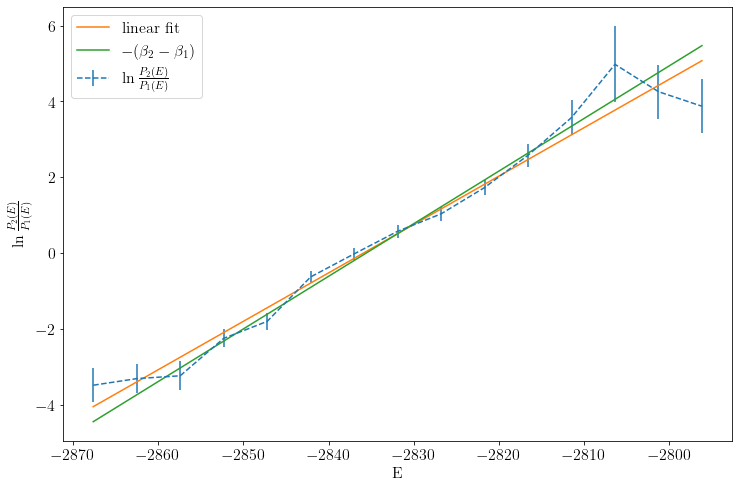

In [456]:
plt.figure(figsize=(12, 8))
plt.errorbar(centers, np.log(h2 / h1), yerr=np.sqrt(var), fmt='--', label=r'$\ln\frac{P_2(E)}{P_1(E)}$')
plt.plot(centers, m * centers + b, label='linear fit')
plt.plot(centers, slope * centers + shift, label=r'$-(\beta_2 - \beta_1)$')
plt.xlabel("E")
plt.ylabel(r'$\ln\frac{P_2(E)}{P_1(E)}$')
plt.legend();

In [ ]:
# Physical Validation

In [457]:
import physical_validation as pv

In [458]:
units = pv.data.UnitData(
    kb=1.0,
    energy_str=r'$\epsilon$',
    energy_conversion=1.0,
    length_str='σ',
    length_conversion=1.0,
    volume_str='σ³',
    volume_conversion=1.0,
    temperature_str='-',
    temperature_conversion=1.0,
    pressure_str='-',
    pressure_conversion=1.0,
    time_str=r'$\tau$',
    time_conversion=1.0
)

sd1 = pv.data.SimulationData()
sd1.system = pv.data.SystemData(
    natoms=nparticles,
)
sd1.units = units
sd1.ensemble = pv.data.EnsembleData(
    ensemble="NVT",
    natoms=nparticles,
    volume=volume,
    temperature=t1
)
sd1.observables = pv.data.ObservableData(
    potential_energy=props1.energy
)

sd2 = pv.data.SimulationData()
sd2.system = pv.data.SystemData(
    natoms=nparticles,
)
sd2.units = units
sd2.ensemble = pv.data.EnsembleData(
    ensemble="NVT",
    natoms=nparticles,
    volume=volume,
    temperature=t2
)
sd2.observables = pv.data.ObservableData(
    potential_energy=props2.energy
)

After equilibration, decorrelation and tail pruning, 6.48% (1620 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 6.30% (1574 frames) of original Trajectory 2 remain.
Overlap is 67.0% of trajectory 1 and 67.0% of trajectory 2.
Rule of thumb estimates that dT = 0.1 would be optimal (currently, dT = 0.1)
Maximum Likelihood Analysis (analytical error)
Free energy
    373.88978 +/- 15.46902
Estimated slope                  |  True slope
    0.131853  +/- 0.005454       |  0.138889 
    (1.29 quantiles from true slope)
Estimated dT                     |  True dT
    0.1    +/- 0.0               |  0.1   


/usr/ITT/bauer/PhD/Code/sargas/sargas_venv/lib/python3.8/site-packages/physical_validation/util/plot.py:147: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[1.2899392936216836]

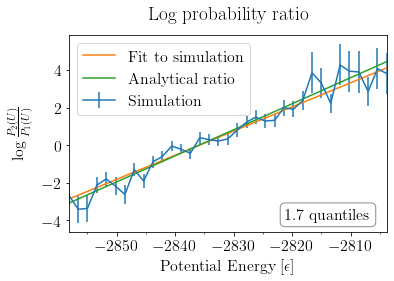

In [459]:
pv.ensemble.check(
    data_sim_one=sd1,
    data_sim_two=sd2,
    screen=True
)

# NPT

In [2]:
nparticles = 500

density = 9e-1
volume = nparticles / density
temperature = 9e-1
pressure = 2.6
rc = 3.0

potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
configuration = Configuration.from_lattice(nparticles, density)
system = System(configuration, potential)

displace_particle = MCMove.displace_particle(0.1, 0.4, temperature)
change_volume = MCMove.change_volume(1.0, 0.5, pressure, temperature)
mc = MonteCarlo([displace_particle, change_volume], [nparticles, 1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [3]:
%%time
simulation.run(1_000_000)

CPU times: user 9.96 s, sys: 11.3 ms, total: 9.97 s
Wall time: 9.95 s


In [4]:
#simulation.deactivate_propagator_updates()
props = Observer.properties(1000)
simulation.add_observer(props)
widom = Observer.widom_insertion(100)
simulation.add_observer(widom)

In [5]:
simulation.run(1_000_000)

In [6]:
properties = pd.DataFrame(props.data)

In [7]:
print("u = {:.5e} +- {:.5e}".format(properties.energy.mean() / system.nparticles, properties.energy.sem() / system.nparticles))

u = -6.16165e+00 +- 1.36564e-03


In [8]:
print("p = {:.5e} +- {:.5e}".format(properties.pressure.mean() + properties.density.mean() / temperature, properties.pressure.sem()))

p = 2.86429e+00 +- 6.98666e-03


In [9]:
print("v = {:.5e} +- {:.5e}".format(properties.volume.mean(), properties.volume.sem()))

v = 5.55556e+02 +- 3.59689e-15


In [10]:
properties.describe()

,nparticles,density,volume,pressure,energy,virial
count,1000.0,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,500.0,9.000000e-01,5.555556e+02,1.864288,-3080.825270,3944.138593
std,0.0,2.221557e-16,1.137437e-13,0.220937,21.592686,368.229161
min,500.0,9.000000e-01,5.555556e+02,1.105959,-3156.658609,2680.256858
25%,500.0,9.000000e-01,5.555556e+02,1.716439,-3095.848512,3697.723992
50%,500.0,9.000000e-01,5.555556e+02,1.843122,-3082.570009,3908.862415
75%,500.0,9.000000e-01,5.555556e+02,2.004506,-3066.433338,4177.835927
max,500.0,9.000000e-01,5.555556e+02,2.653278,-3005.244343,5259.121831


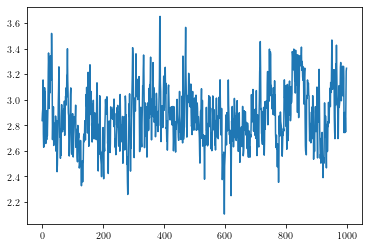

In [11]:
plt.plot(properties.pressure + properties.density / temperature)

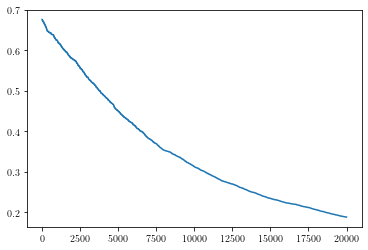

In [64]:
plt.plot(properties.density)

# $\mu$VT Simulation

In [8]:
density = 0.8
nparticles = 500
volume = nparticles / density
temperature = 0.8
rc = 3.0

potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
configuration = Configuration.from_lattice(nparticles, density, max_nparticles=800)
system = System(configuration, potential)

displace_particle = MCMove.displace_particle(0.1, 0.4, temperature)
insert_delete_particle = MCMove.insert_delete_particle(0, temperature)
mc = MonteCarlo([displace_particle, insert_delete_particle], [50, 1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [9]:
%%time
print("Equilibration")
simulation.run(nparticles * 1000)

simulation.deactivate_propagator_updates()
props = Observer.properties(100)
simulation.add_observer(props)

print("Production")
simulation.run(nparticles * 5000)

Equilibration
Production
CPU times: user 1.12 s, sys: 7.03 ms, total: 1.13 s
Wall time: 1.13 s


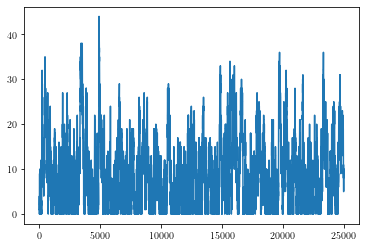

In [10]:
properties = pd.DataFrame(props.data)
plt.plot(properties.nparticles)